## Import statements

In [1]:
import copy
import random
import time
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models

from util.dataset_util import DatasetUtil
from util.dataset_vgg_utk import ValDatasetVggUtk
from util.imagenet import Imagenet
from util.imagenet_utk import ImagenetUtk
from util.imagenet_vgg import ImagenetVgg

# Use CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using %s for training/validating the model" % device)

# setting up seeds for reproducibility
torch.manual_seed(0)


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


Using cuda:0 for training/validating the model


## Data Preprocessing

In [4]:
# Parameter settings for batching
BATCH_SIZE = 128
# 64 <= image_size <= 224
IMAGE_SIZE = 64
# 0 <= WORKER_COUNT
WORKER_COUNT = 7
# 1 <= NUMBER_OF_CLASSES <= 201
NUMBER_OF_CLASSES = 4
# 0 < TRAIN_IMAGE_COUNT <= 500
TRAIN_IMAGE_COUNT = 500
# True/False
shuffle = True

# Use this line if you're executing for the first time
# data_utility = DatasetUtil(base_dir="./datasets", total_class_count=10, img_size=64, train_img_count=500,
#                            vgg_download=True)
data_utility = DatasetUtil(base_dir="./datasets", total_class_count=NUMBER_OF_CLASSES, img_size=IMAGE_SIZE,
                           train_img_count=TRAIN_IMAGE_COUNT,
                           load_from_json=False)
data_utility.save_all_json()

imagenet_datasets = {'train': Imagenet(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE),
                     'val': Imagenet(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE, validation=True)}
imagenet_dataloaders = {'train': DataLoader(dataset=imagenet_datasets['train'], batch_size=BATCH_SIZE,
                                            shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker),
                        'val': DataLoader(dataset=imagenet_datasets['val'], batch_size=BATCH_SIZE,
                                          shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker)}

# Load data for Tiny ImageNet + UTKFace
utk_datasets = {'train': ImagenetUtk(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE),
                'val': ImagenetUtk(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE, validation=True)}
utk_dataloaders = {'train': DataLoader(dataset=utk_datasets['train'], batch_size=BATCH_SIZE,
                                       shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker),
                   'val': DataLoader(dataset=utk_datasets['val'], batch_size=BATCH_SIZE,
                                     shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker)}

# Load data for Tiny ImageNet + VGG
vgg_datasets = {'train': ImagenetVgg(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE),
                'val': ImagenetVgg(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE, validation=True)}
vgg_dataloaders = {'train': DataLoader(dataset=vgg_datasets['train'], batch_size=BATCH_SIZE,
                                       shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker),
                   'val': DataLoader(dataset=vgg_datasets['val'], batch_size=BATCH_SIZE,
                                     shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker)}

utk_vgg_dataset = ValDatasetVggUtk(du=data_utility, image_size=IMAGE_SIZE)
utk_vgg_dataloader = DataLoader(dataset=utk_vgg_dataset, batch_size=BATCH_SIZE,
                                shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker)


# this classes list will contain class names of items[0] to [9] in string
# class_names = utk_datasets['train'].get_class_names()

05/29/2021 08:51:30 PM - INFO: Resized images saved.
05/29/2021 08:51:30 PM - INFO: int2name saved as: ./datasets/modified_datasets/int2name.json
05/29/2021 08:51:30 PM - INFO: Tiny ImageNet id2int saved as: ./datasets/modified_datasets/imagenet/id2int.json
05/29/2021 08:51:30 PM - INFO: Tiny ImageNet id2name saved as: ./datasets/modified_datasets/imagenet/id2name.json
05/29/2021 08:51:30 PM - INFO: Tiny ImageNet training list saved as: ./datasets/modified_datasets/imagenet/train.json
05/29/2021 08:51:30 PM - INFO: Tiny ImageNet validation list saved as: ./datasets/modified_datasets/imagenet/validation.json
05/29/2021 08:51:30 PM - INFO: UTKFace training list saved as: ./datasets/modified_datasets/utk/train.json
05/29/2021 08:51:30 PM - INFO: UTKFace validation list saved as: ./datasets/modified_datasets/utk/validation.json
05/29/2021 08:51:30 PM - INFO: VGG training list saved as: ./datasets/modified_datasets/vgg/train.json
05/29/2021 08:51:30 PM - INFO: VGG validation list saved as: 

## Dataset preview

In [3]:
def info_data(image_datasets: dict, dataloaders: dict) -> None:
    """
    Prints info. about datasets/dataloaders; uncomment if necessary
    :return: None
    """
    cls = image_datasets["train"].get_class_names()
    print('Number of classes: %s' % len(cls))
    print('Class names: %s' % cls)
    print('Length of training dataset: %s' % len(image_datasets['train']))
    print('Length of validation dataset: %s' % len(image_datasets['val']))
    print('Batch size: %s' % BATCH_SIZE)
    print('Number of batches in the training dataloader: %s' % len(dataloaders['train']))
    print('Number of batches in the training dataloader: %s' % len(dataloaders['val']))
    print('Device: %s\n' % device)


print("Imagenet dataset statistics")
info_data(imagenet_datasets, imagenet_dataloaders)
print("UTKFace dataset statistics")
info_data(utk_datasets, utk_dataloaders)
print("VGG Face dataset statistics")
info_data(vgg_datasets, vgg_dataloaders)

Imagenet dataset statistics
Number of classes: 4
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'face']
Length of training dataset: 1500
Length of validation dataset: 150
Batch size: 128
Number of batches in the training dataloader: 12
Number of batches in the training dataloader: 2
Device: cuda:0

UTKFace dataset statistics
Number of classes: 4
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'face']
Length of training dataset: 2000
Length of validation dataset: 200
Batch size: 128
Number of batches in the training dataloader: 16
Number of batches in the training dataloader: 2
Device: cuda:0

VGG Face dataset statistics
Number of classes: 4
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'face']
Length of training dataset: 2000
Length of validation dataset: 200
Batch size: 128
Number of batches in the training dataloader: 16
Number of batches in the tr

In [13]:
def image_show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


def get_preview(dataloaders: dict, title: str):
    """
    Preview 64 images in training dataset
    :param dataloaders: Dataloader dictionary to use to print images
    :param title: Title of the preview
    :return: None
    """
    # Get the first batch of training data
    inputs, classes = list(dataloaders['train'])[0]

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs[:64], normalize=True)

    image_show(out, title=title)

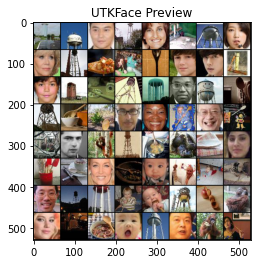

In [14]:
get_preview(dataloaders=utk_dataloaders, title="UTKFace Preview")

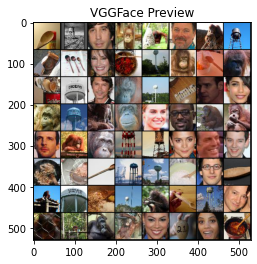

In [15]:
get_preview(dataloaders=vgg_dataloaders, title="VGGFace Preview")

## Model Training

In [8]:
# Parameters
EPOCH = 25
LEARNING_RATE = 0.001
SGD_MOMENTUM = 0.9
SGD_WEIGHT_DECAY = 0.0001
LR_DECAY_STEP_SIZE = 7
LR_DECAY_FACTOR = 0.1


def train_model(model_ft: Any, dataloaders, image_datasets):
    def _train_model(model: Any, criterion, optimizer, scheduler, dl, img_datasets):
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(EPOCH):
            print('Epoch {}/{}'.format(epoch, EPOCH - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for imgs, labels in dl[phase]:
                    # print('Iterating ', labels, '...')
                    torch.cuda.empty_cache()  # clean up cache
                    #print(torch.cuda.memory_summary(device=device, abbreviated=False))
                    imgs = imgs.float().to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(imgs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * imgs.size(0)
                    running_corrects += torch.eq(preds, labels.data).sum()
                if phase == 'train':
                    scheduler.step()
                dataset_size = len(img_datasets[phase])
                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model

    num_ftrs = model_ft.fc.in_features

    # TODO: Here the size of each output sample is set to 2 it is the number of classes.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, len(image_datasets['train'].get_class_names()))

    model_ft = model_ft.to(device)

    loss_fn = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, weight_decay=SGD_WEIGHT_DECAY,
                             momentum=SGD_MOMENTUM)

    # Decay LR by a factor of 0.1 every 7 epochs
    # TODO: Perhaps we can consider ReduceLROnPlateau instead
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=LR_DECAY_STEP_SIZE, gamma=LR_DECAY_FACTOR)

    return _train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                        dl=dataloaders, img_datasets=image_datasets)

# model_arch = models.resnet50()

In [9]:
imgnet_model_ft = train_model(models.resnet50(), dataloaders=imagenet_dataloaders, image_datasets=imagenet_datasets)

Epoch 0/24
----------
train Loss: 1.5192 Acc: 0.2830
val Loss: 1.5286 Acc: 0.2700

Epoch 1/24
----------
train Loss: 1.3898 Acc: 0.3290
val Loss: 1.8262 Acc: 0.2800

Epoch 2/24
----------
train Loss: 1.2891 Acc: 0.4020
val Loss: 1.4781 Acc: 0.4200

Epoch 3/24
----------
train Loss: 1.2185 Acc: 0.4470
val Loss: 1.2713 Acc: 0.4650

Epoch 4/24
----------
train Loss: 1.1550 Acc: 0.4975
val Loss: 1.0974 Acc: 0.5500

Epoch 5/24
----------
train Loss: 1.0760 Acc: 0.5365
val Loss: 1.0534 Acc: 0.5350

Epoch 6/24
----------
train Loss: 1.0228 Acc: 0.5890
val Loss: 0.9877 Acc: 0.6150

Epoch 7/24
----------
train Loss: 0.9581 Acc: 0.6445
val Loss: 0.9222 Acc: 0.5850

Epoch 8/24
----------
train Loss: 0.9337 Acc: 0.6200
val Loss: 0.9073 Acc: 0.6050

Epoch 9/24
----------
train Loss: 0.9286 Acc: 0.6375
val Loss: 0.8803 Acc: 0.6450

Epoch 10/24
----------
train Loss: 0.9046 Acc: 0.6580
val Loss: 0.8792 Acc: 0.6450

Epoch 11/24
----------
train Loss: 0.8893 Acc: 0.6550
val Loss: 0.8772 Acc: 0.6200

Ep

In [10]:
utk_model_ft = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets)

Epoch 0/24
----------
train Loss: 1.4003 Acc: 0.2950
val Loss: 2.4564 Acc: 0.2850

Epoch 1/24
----------
train Loss: 1.2877 Acc: 0.3875
val Loss: 2.2038 Acc: 0.3200

Epoch 2/24
----------
train Loss: 1.2364 Acc: 0.4245
val Loss: 1.1903 Acc: 0.4600

Epoch 3/24
----------
train Loss: 1.1197 Acc: 0.5150
val Loss: 1.1256 Acc: 0.5050

Epoch 4/24
----------
train Loss: 1.0734 Acc: 0.4990
val Loss: 1.1396 Acc: 0.4600

Epoch 5/24
----------
train Loss: 1.0437 Acc: 0.5635
val Loss: 1.0971 Acc: 0.5650

Epoch 6/24
----------
train Loss: 1.0030 Acc: 0.5850
val Loss: 1.0925 Acc: 0.4900

Epoch 7/24
----------
train Loss: 0.9483 Acc: 0.6275
val Loss: 1.0043 Acc: 0.5900

Epoch 8/24
----------
train Loss: 0.9290 Acc: 0.6265
val Loss: 0.9749 Acc: 0.5950

Epoch 9/24
----------
train Loss: 0.8947 Acc: 0.6525
val Loss: 0.9773 Acc: 0.6000

Epoch 10/24
----------
train Loss: 0.8869 Acc: 0.6510
val Loss: 0.9825 Acc: 0.5900

Epoch 11/24
----------
train Loss: 0.8697 Acc: 0.6685
val Loss: 0.9765 Acc: 0.5700

Ep

In [11]:
vgg_model_ft = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets)

Epoch 0/24
----------
train Loss: 1.4592 Acc: 0.2905
val Loss: 7.3405 Acc: 0.2500

Epoch 1/24
----------
train Loss: 1.3766 Acc: 0.3290
val Loss: 2.0443 Acc: 0.2950

Epoch 2/24
----------
train Loss: 1.2835 Acc: 0.3915
val Loss: 1.7468 Acc: 0.4000

Epoch 3/24
----------
train Loss: 1.1678 Acc: 0.4530
val Loss: 1.4178 Acc: 0.4250

Epoch 4/24
----------
train Loss: 1.1015 Acc: 0.4940
val Loss: 1.3532 Acc: 0.4700

Epoch 5/24
----------
train Loss: 1.0670 Acc: 0.5220
val Loss: 1.2704 Acc: 0.4300

Epoch 6/24
----------
train Loss: 1.0112 Acc: 0.5695
val Loss: 1.1046 Acc: 0.4600

Epoch 7/24
----------
train Loss: 0.9523 Acc: 0.5900
val Loss: 1.0274 Acc: 0.5600

Epoch 8/24
----------
train Loss: 0.9276 Acc: 0.6150
val Loss: 1.0043 Acc: 0.5400

Epoch 9/24
----------
train Loss: 0.9146 Acc: 0.6445
val Loss: 0.9976 Acc: 0.5350

Epoch 10/24
----------
train Loss: 0.8845 Acc: 0.6550
val Loss: 0.9830 Acc: 0.5650

Epoch 11/24
----------
train Loss: 0.8779 Acc: 0.6550
val Loss: 0.9856 Acc: 0.5700

Ep

## Model Visualization

In [34]:
def visualize_model(model, datasets: dict, dataloaders: dict, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    # fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataloaders['val']):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for j in range(imgs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                # TODO: Using .get_class_names() for actual prediction is discouraged as index may not be correct.
                ax.set_title(('predicted:' + datasets["train"].get_class_name(preds[j]) +
                              '\n answer:' + datasets["train"].get_class_name(labels.cpu().numpy()[images_so_far - 1])))
                image_show(imgs.int().cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

64
64
64
64
64
64
64
64
64
64


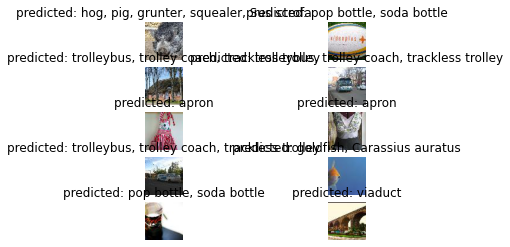

In [35]:
# Visualize utk models
visualize_model(utk_model_ft, utk_datasets, utk_dataloaders)
# Visualize vgg models
visualize_model(vgg_model_ft, vgg_datasets, vgg_dataloaders)